Particle filter models
------------------------------------------------------------

In [1]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Union, Optional, List, NamedTuple, Any, Tuple
from torch import Tensor
from torch.distributions import Normal
import gc

## Data

Some cosine waves. Observations are created as 1d heatmaps encoding the current values as the locations of a gaussian.

Noise is added to the ground truth coordinates as well as the heatmaps.

In [2]:
import data
import util
import train
import eval_

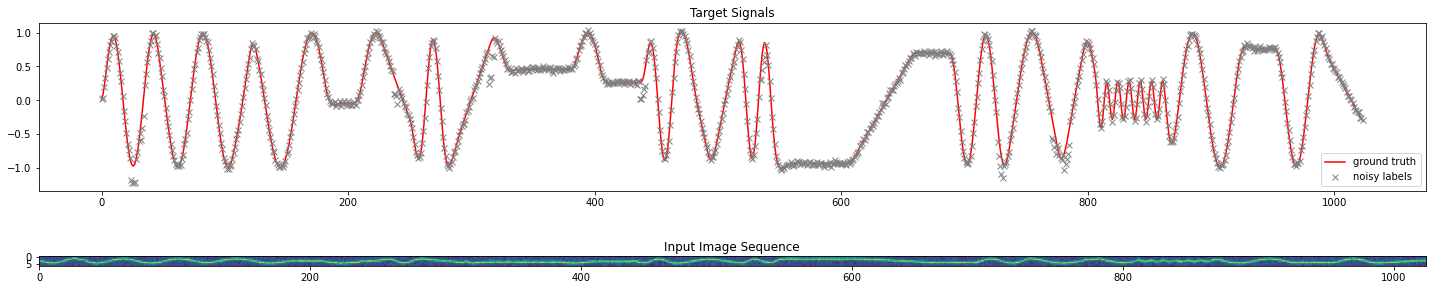

In [3]:
testdata = eval_.make_testset()

_ = data.plot_sequence(*testdata[0])
plt.tight_layout()

## Model

In [4]:
device = 'cuda'

In [5]:
from models import Out, Backbone

In [6]:
class GaussianObservationModel(nn.Module):
    '''
    This model predicts a normal distribution based on the observed images, 
    representing what the true coordinate might be. (Done in self.forward)
    Then it scores particles by evaluating the distribution at the particle 
    position. (Done in self.weight)
    '''
    def __init__(self, state_features):
        super().__init__()
        self.backbone = Backbone()
        self.num_hidden = 16
        # Outputs mean and scale base on image
        self.fc = nn.Sequential(
            nn.Linear(self.backbone.num_features, self.num_hidden),
            nn.LayerNorm(self.num_hidden),
            nn.SiLU(inplace=True),
            nn.Linear(self.num_hidden, 2))
        # Project the particle state to the coordinate
        self.projection = nn.Sequential(
            nn.Linear(state_features, self.num_hidden),
            nn.LayerNorm(self.num_hidden),
            nn.SiLU(inplace=True),
            nn.Linear(self.num_hidden, 1))
        self.state_features = state_features
 
    def forward(self, visuals):
        L, B, C, W = visuals.shape
        x = self.backbone(util.seq_as_batch(visuals))
        x = self.fc(x)
        x = x.view(L, B, x.size(-1))
        means = x[...,0]
        stds = F.softplus(x[...,1])+1.e-6
        return means, stds
    
    def _log_prob(self, means, stds, particles):
        return Normal(means[...,None], stds[...,None]).log_prob(particles)[...,0]
        
    def weight(self, seq_index, hidden_vars, particles):
        P, B, C = particles.shape
        means, stds = hidden_vars
        L = means.size(0)
        assert C == self.state_features
        assert means.shape == (L, B), f"Bad shape {means.shape}"
        assert stds.shape == (L, B), f"Bad shape {stds.shape}"
        # Pick out from the correct sequence index. Then add particle dimension in front.
        means, stds = (means[None,seq_index,...],stds[None,seq_index,...])
        positions = self.projection(particles.view(P*B,C)).view(P,B,1)
        out = -self._log_prob(means, stds, positions)
        assert out.shape == (P, B)
        return out


class NeuralObservationModel(nn.Module):
    '''
    This model concatenate the image features with the particle features and outputs a particle weight directly.
    '''
    def __init__(self, state_features):
        super().__init__()
        self.backbone = Backbone()
        self.state_features = state_features
        self.num_hidden = 64
        self.fc = nn.Sequential(
            nn.Linear(self.backbone.num_features + state_features, self.num_hidden),
            nn.LayerNorm(self.num_hidden),
            nn.SiLU(inplace=True),
            nn.Linear(self.num_hidden, 1))
 
    def forward(self, visuals):
        L, B, C, W = visuals.shape
        x = self.backbone(util.seq_as_batch(visuals))
        x = x.view(L, B, self.backbone.num_features)
        return x
        
    def weight(self, seq_index, hidden_vars, particles):
        P, B, C = particles.shape
        z = hidden_vars
        L = z.size(0)
        assert C == self.state_features
        assert z.shape == (L, B, self.backbone.num_features), f"Bad shape {z.shape}"
        # Pick out from the correct sequence index. Then add particle dimension in front.
        z = torch.cat([z[seq_index,None,...].expand(P,B,self.backbone.num_features), particles], dim=-1)
        out = self.fc(z).view(P,B)
        assert out.shape == (P, B)
        return out


MotionState = Tensor


class NeuralMotionModel(nn.Module):
    '''
    A simple recurrent network with noisy output.
    It advances the particle states by one time step per forward() call.
    '''
    def __init__(self, state_features):
        super().__init__()
        # Internally there is an LSTM. Because its state is so oddly split into 
        # two tensors of equal size, the total state size must be even.
        # Meaning, in this model, the concatenation of h and c tensors is considered
        # as particle state.
        assert state_features % 2 == 0, "Number of state features must be even"
        self.hidden_size = state_features//2
        self.observable_features = 1
        self.dropout_prob = 0.2
        self.layer = nn.LSTMCell(0, self.hidden_size)
        # This projection is used to project the particle state into the 
        # label space for computing the loss.
        self.projection = nn.Linear(state_features, self.observable_features)
    
    def create_initial_state(self, num_particles, batchsize, device):
        h_0 = torch.randn(
            num_particles, batchsize, self.hidden_size, device=device)
        c_0 = torch.randn(
            num_particles, batchsize, self.hidden_size, device=device)
        return self._pack(h_0, c_0)
    
    def _unpack(self, state : MotionState):
        h = state[...,:self.hidden_size]
        c = state[...,self.hidden_size:]
        return h, c

    def _pack(self, h, c):
        return torch.cat([h,c],dim=-1)

    def get_observation(self, state : MotionState):
        P, B, C = state.shape
        assert C == self.hidden_size*2
        return self.projection(state.view(P*B,C)).view(P,B,self.observable_features)
    
    def forward(self, state : MotionState):
        h_0, c_0 = self._unpack(state)
        P, B, C = h_0.shape
        assert C == self.hidden_size

        # Dummy tensor with 0 features. Because we have no extra input for the LSTM. Only h and c.
        x = h_0.new_zeros((P*B, 0))

        h_0, c_0 = h_0.view(P*B,C), c_0.view(P*B,C)

        h_0, c_0 = self.layer(x, (h_0, c_0))
        new_state = self._pack(h_0, c_0)

        # Add noise, so particles drift apart.
        # Might as well use additive gaussian noise or anything else. Idk .. probably makes no difference.
        new_state = F.dropout1d(new_state, self.dropout_prob)
        
        new_state = new_state.view(P,B,C*2)

        observation = self.get_observation(new_state)

        return observation, new_state

    
def _test_observe():
    L, B, C, W = 8, 32, 1, 7
    model = GaussianObservationModel(3).to(device)
    hidden_observation_representation = model(torch.rand((L,B,C,W), device=device))
    for h in hidden_observation_representation:
        assert h.shape[:2] == (L,B), f"Bad hidden state shape: {h.shape}"
    seq_index = 7
    P = 10
    x = torch.rand((P, B, 3), device=device)
    particle_weights = model.weight(seq_index, hidden_observation_representation, x)
    assert particle_weights.shape == (P, B)

def _test_neural_observe():
    L, B, C, W = 8, 32, 1, 7
    model = NeuralObservationModel(3).to(device)
    hidden_observation_representation = model(torch.rand((L,B,C,W), device=device))
    seq_index = 7
    P = 10
    x = torch.rand((P, B, 3), device=device)
    particle_weights = model.weight(seq_index, hidden_observation_representation, x)
    assert particle_weights.shape == (P, B)

def _test_motionmodel():
    P, B, C = 16, 32, 1
    model = NeuralMotionModel(6).to(device)
    state = model.create_initial_state(P, B, device)
    o, newstate = model(state)
    assert o.shape == (P,B,C), f"bad shape {o.shape}"
    assert state.shape == newstate.shape, f"bad shapes {state.shape} vs {newstate.shape}"
    
_test_observe()
_test_motionmodel()
_test_neural_observe()

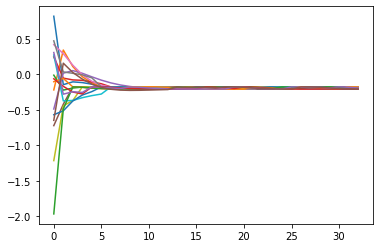

In [7]:
# Plot some trajectories for the untrained model
@torch.no_grad()
def test_plot_traj(mm):
    L = 32
    P = 16
    s = mm.create_initial_state(P, 1, 'cpu')
    traj = [ mm.get_observation(s) ]
    for _ in range(L):
        o, s = mm(s)
        traj.append(o)
    traj = torch.stack(traj, dim=0)
    assert traj.shape == (L+1, P, 1, 1)
    fig, ax = plt.subplots(1,1)
    for i in range(P):
        ax.plot(traj[:,i,0,0])
    plt.show()

test_plot_traj(NeuralMotionModel(32))

In [8]:
class PfModel(nn.Module):
    '''
    The particle filter model:
    It follows the basic particle filter approach - there are particle which move through their state space according to some motion model.
    This model is noisy so their states diverge over time. An observation model takes the input data and judges the likelihood of each particle
    matching that observation. The result is a weight for each of the particles. Using the weights we can compute posterior statistics.
    '''
    def __init__(self, 
        MotionModelClass = NeuralMotionModel, 
        ObservationModelClass = GaussianObservationModel):
        super().__init__()
        self.state_features = 32
        self.motionmodel = MotionModelClass(self.state_features)
        self.observationmodel = ObservationModelClass(self.state_features)
        self.num_particles = 128

    @property
    def device(self):
        return next(self.parameters()).device
        
    def create_initial_state(self, batchsize):
        # Return particle states
        return self.motionmodel.create_initial_state(self.num_particles, batchsize, self.device)
    
    def _resample(self, particle_weights : Tensor, states : MotionState):
        P, B = particle_weights.shape
        states.shape[:2] == (P,B), f"bad shape {states.shape} vs {particle_weights.shape}"
        indices = torch.multinomial(particle_weights.T, P, replacement=True).T
        return util.gather_particles(states, indices) 
    
    def forward(self, visuals : Tensor, states : MotionState):
        P = self.num_particles
        L, B, C, W = visuals.shape
        # Preprocess the image sequence into a sequence of feature vectors
        hidden_observation_repr = self.observationmodel(visuals)
        estimates = []
        estimates_std = []
        weight_logits = None
        for i in range(L):
            # Prediction step
            observation_projections, states = self.motionmodel(states)
            assert observation_projections.shape[:2] == (P,B)
            # Compute weights in terms of unnormalized log probabilities
            new_weight_logits = self.observationmodel.weight(i, hidden_observation_repr, states)
            
            # Accumulate weights if not resampling
            # (Is this done correctly?)
            assert new_weight_logits.shape == (P, B)
            if weight_logits is None:
                weight_logits = new_weight_logits
            else:
                weight_logits += new_weight_logits
            # Compute normalized weights
            weights = F.softmax(weight_logits, dim=0) # Over the particle dimension
            assert weights.shape == (P, B)

            # Compute statistics for the posterior position observation - only coordinate, no image.
            mean = (weights[...,None] * observation_projections).sum(dim=0)
            estimates.append(mean)
            estimates_std.append(((observation_projections - mean[None,...]).square()*weights[...,None]).sum(dim=0).sqrt())
            # Running it over long sequences needs resampling. For training on shorter sequences maybe it is okay to abolish 
            # the complexity of backprop through stochastic compute graphs.
            if not self.training:
                states = self._resample(weights, states)
                weight_logits = None
        return Out(torch.stack(estimates, dim=0), torch.stack(estimates_std,dim=0)), states

In [9]:
def test_particlefilter():
    model = PfModel().to(device)
    model.train()
    print ("Num Parameters: ", sum([p.numel() for p in model.parameters()]))
    B = 5
    L = 32
    W = 7
    L = 64
    states = model.create_initial_state(B)
    seqs = torch.zeros((L,B,1,W), device=device)
    out, _ = model(seqs, states)
    assert out.y.shape == (L,B,1)

    model.eval()
    out, _ = model(seqs, states)
    assert out.y.shape == (L,B,1)

test_particlefilter()

Num Parameters:  4412


## Training

In [10]:
num_samples = 8 * 1024 * 1024
learning_rate = 0.01

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

from models import SingleFrameRegression

In [11]:
sfmodel = SingleFrameRegression().to(device)
train.train_singleframe_model(sfmodel, 4096, num_samples, learning_rate)

Loss: 0.00395: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [00:08<00:00, 244.88it/s]


sfmodel


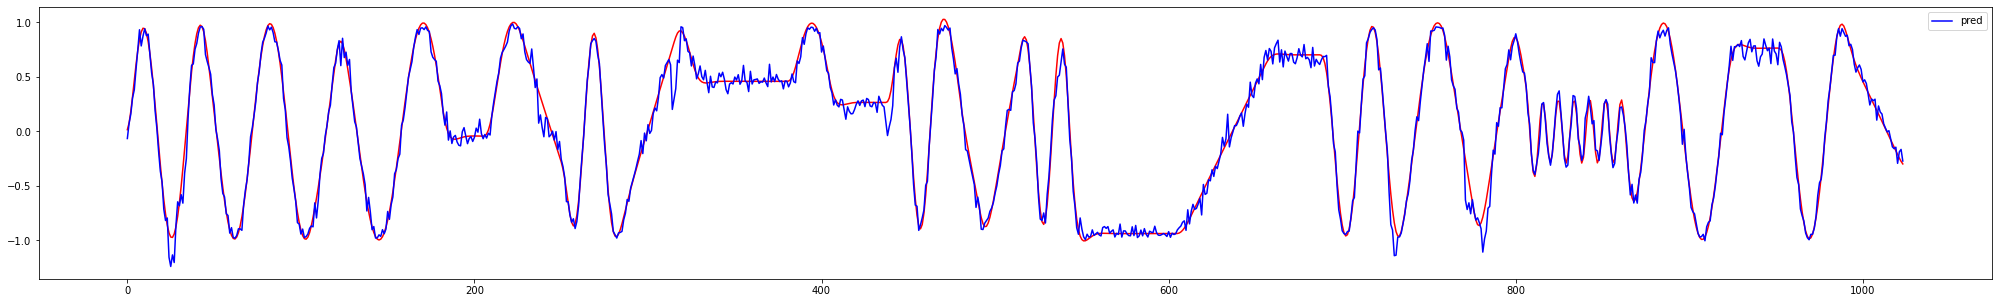

In [12]:
print('sfmodel'); eval_.evaluate(sfmodel, testdata)

In [13]:
pfmodel = PfModel().to(device)
train.train_sequence_model(pfmodel, 1024, 32, num_samples, learning_rate*10., None, None)

Loss: 0.02507, Smoothness nan: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:35<00:00,  2.69it/s]


pfmodel


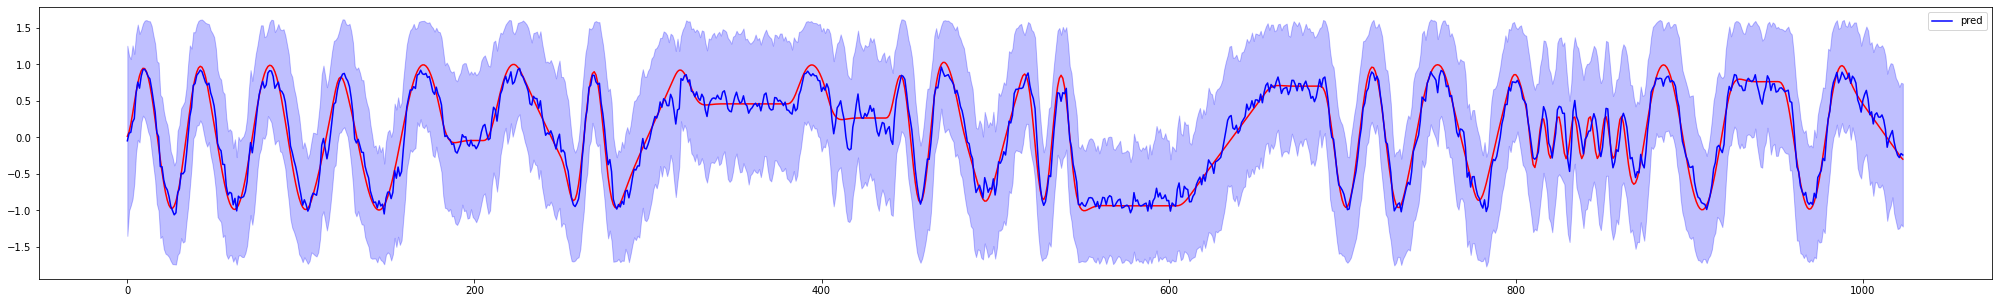

In [14]:
print('pfmodel'); eval_.evaluate(pfmodel, testdata)

In [15]:
del pfmodel
cleanup()

In [16]:
pfmodel2 = PfModel(ObservationModelClass=NeuralObservationModel).to(device)
train.train_sequence_model(pfmodel2, 512, 32, num_samples, learning_rate*10., None, None)

Loss: 0.01983, Smoothness nan: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [02:08<00:00,  3.97it/s]


pfmodel2


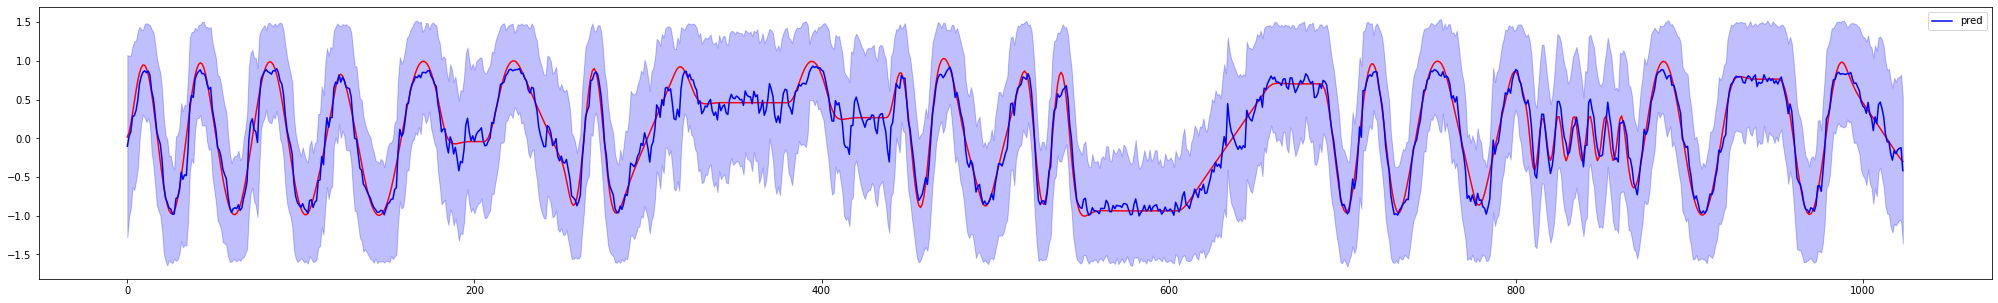

In [17]:
print('pfmodel2'); eval_.evaluate(pfmodel2, testdata)

In [18]:
del pfmodel2
cleanup()

In [19]:
pfmodel2_smoothed = PfModel(ObservationModelClass=NeuralObservationModel).to(device)
train.train_sequence_model(pfmodel2_smoothed, 512, 32, num_samples, learning_rate*10., 5., train.RobustSmooth2ndDerivLoss(eps=0.02).to(device))

Loss: 0.03573, Smoothness 0.00609: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [02:09<00:00,  3.97it/s]


smoothed_model2


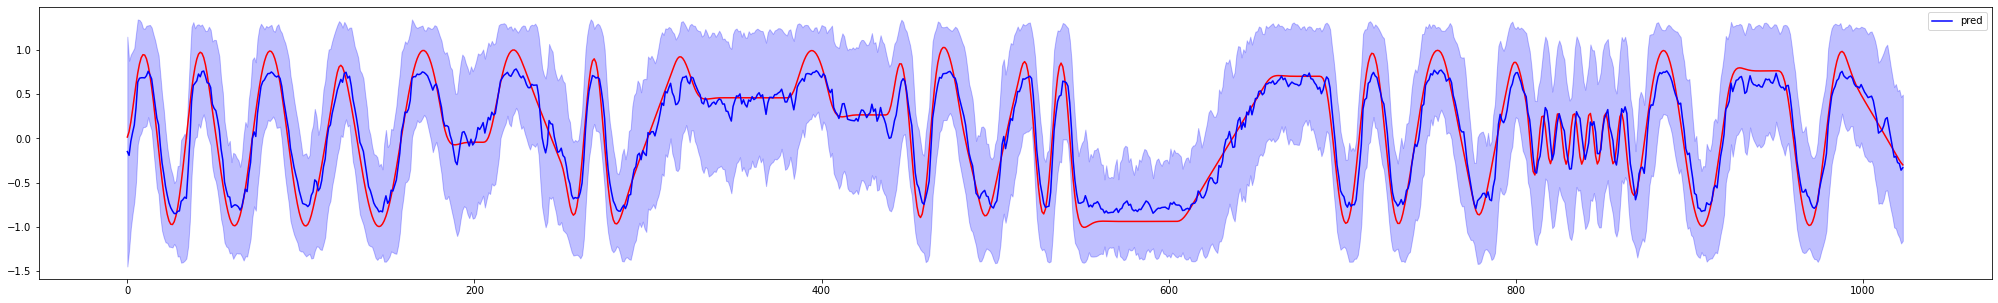

In [20]:
print('smoothed_model2'); eval_.evaluate(pfmodel2_smoothed, testdata)

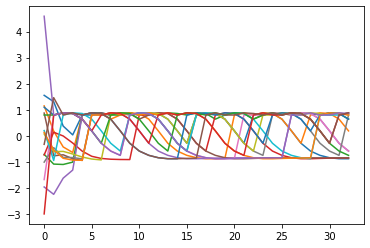

In [22]:
test_plot_traj(pfmodel2_smoothed.motionmodel.cpu())
pfmodel2_smoothed.cuda()
pass

In [23]:
del pfmodel2_smoothed
cleanup()